<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts if a text is written by an AI or by a student.

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Detect AI Generated Text dataset
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [ ]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp
# !pip install seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
# os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import tensorflow as tf
# import keras_core as keras
# import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt


# print("TensorFlow version:", tf.__version__)
# print("Keras version:", keras.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

# Load the Detect AI Generated Text
Let's have a look at all the data files

In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/data/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/data/sample_submission.csv
/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/data/train_prompts.csv
/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/data/test_essays.csv
/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/data/train_essays.csv
/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/data/train_v2_drcat_02.csv


# Explore the dataset

Let's look at the distribution of labels in the training set.

In [ ]:
df_train_prompts = pd.read_csv(DATA_DIR + "train_prompts.csv")
print(df_train_prompts.info())
df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 196.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


**Only two prompts are used in this dataset.**

Let's look at the distribution of text/generated in the training set.

In [ ]:
df_train_essays = pd.read_csv(DATA_DIR + "train_essays.csv")
print(df_train_essays.info())
df_train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Text(0.5, 1.0, 'Distribution of prompt ID')

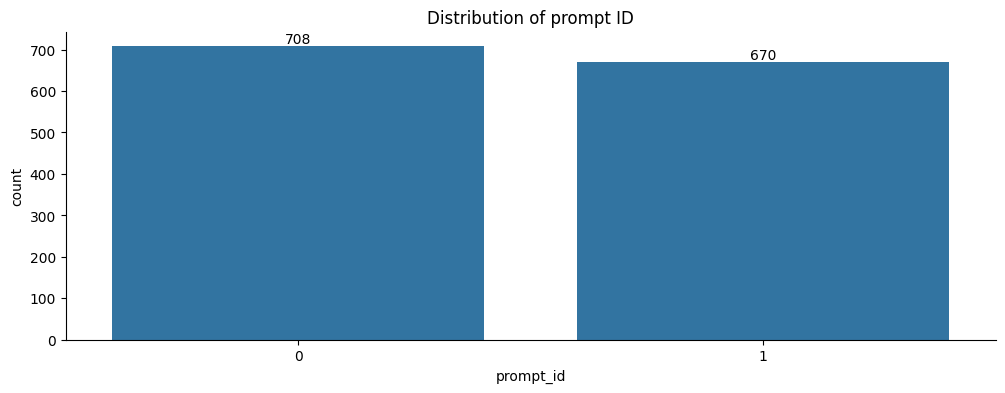

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="prompt_id")

abs_values = df_train_essays['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of Generated Text')

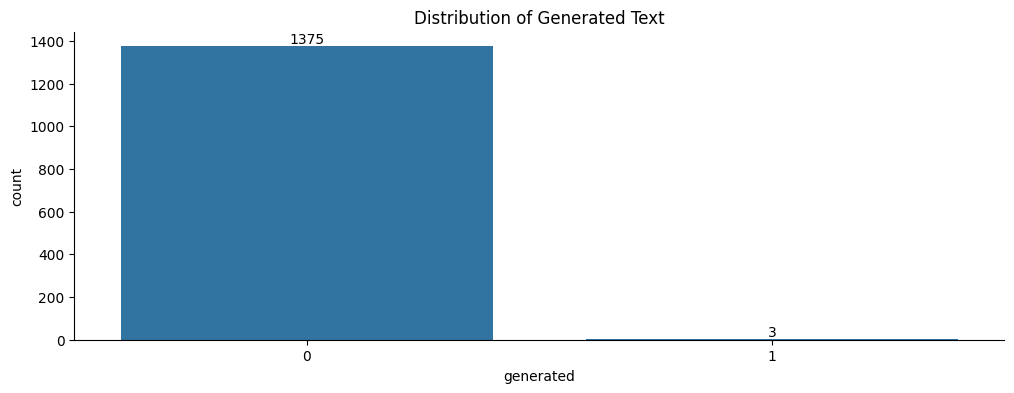

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays,
                   x="generated")

abs_values = df_train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

**1375 essays are written by human and only 3 by AI.**

**The distribution between the two prompts is pretty equal.**

In [ ]:
df_test_essays = pd.read_csv(DATA_DIR + "test_essays.csv")
print(df_test_essays.info())
df_test_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 204.0+ bytes
None


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [ ]:
df_test_essays["text"].apply(lambda x : len(x))

,text
0,12
1,12
2,12


**The test dataset contains only 3 essays. The length of each essay is very small (12 characters).**

# Add new data to the training dataset

As the dataset does not contain any generated data. We will use the dataset created by [DAREK KŁECZEK](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/455517)

In [ ]:
df_train_essays_ext = pd.read_csv(DATA_DIR + 'train_v2_drcat_02.csv')

df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [ ]:
df_train_essays_ext.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of Generated Text')

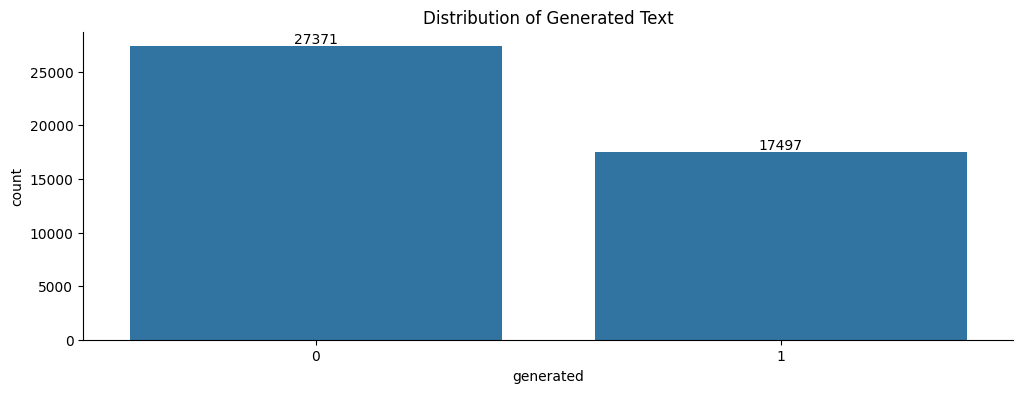

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [ ]:
df_train_essays


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [ ]:
df_train_essays_final = pd.concat([df_train_essays_ext[["text", "generated"]], df_train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46246 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


# Prepare data

Let's count the number of words in each essay

In [ ]:
df_train_essays["text_length"] = df_train_essays["text"].apply(lambda x : len(x.split()))

Text(0.5, 0.98, 'Distribution of the length per essay - Train dataset')

<Figure size 4000x5000 with 0 Axes>

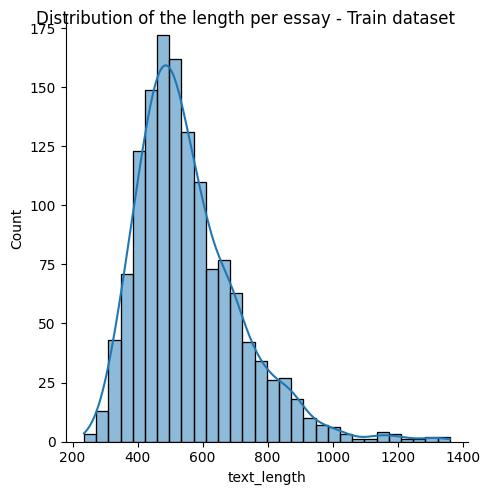

In [ ]:
fig = plt.figure(figsize=(40,50))
plot = sns.displot(data=df_train_essays,
                 x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution of the length per essay - Train dataset")


In [ ]:
df_train_essays["text_length"].mean() + df_train_essays["text_length"].std()

np.float64(716.0440978092684)

# Create the model

In [ ]:
# # We choose 512 because it's the limit of DistilBert
# SEQ_LENGTH = 512

# # Use a shorter sequence length.
# preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
#     "distil_bert_base_en_uncased",
#     sequence_length=SEQ_LENGTH,
# )

# # Pretrained classifier.
# classifier = keras_nlp.models.DistilBertClassifier.from_preset(
#     "distil_bert_base_en_uncased",
#     num_classes=2,
#     activation=None,
#     preprocessor=preprocessor,
# )

# # Re-compile (e.g., with a new learning rate)
# classifier.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=keras.optimizers.Adam(5e-4),
#     metrics=[
#         keras.metrics.SparseCategoricalAccuracy()
#    ]
# )


# # Access backbone programmatically (e.g., to change `trainable`).
# classifier.backbone.trainable = False


# classifier.summary()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import Dataset

from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


In [ ]:
# We choose 512 because it's the limit of DistilBERT
SEQ_LENGTH = 512

# Load tokenizer (equivalent to preprocessor)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load pretrained classifier
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

# Freeze the backbone (all layers except the classification head)
for param in model.distilbert.parameters():
    param.requires_grad = False

# Optimizer (equivalent learning rate)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Loss function (CrossEntropyLoss handles logits by default)
criterion = nn.CrossEntropyLoss()

# Move model to device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f'Using device: {device}')
model.to(device)

# Print model summary
print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0

In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_essays_final["text"],
                                                    df_train_essays_final["generated"],
                                                    test_size=0.33,
                                                    random_state=42)

train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=SEQ_LENGTH)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/30984 [00:00<?, ? examples/s]

Map:   0%|          | 0/15262 [00:00<?, ? examples/s]

In [ ]:
# # Fit
# classifier.fit(x=X_train,
#                y=y_train,
#                validation_data=(X_test, y_test),
#                epochs=1,
#                batch_size=64
#               )

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model.train()
for epoch in range(5):
    total_loss = 0
    correct = 0
    total = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc='epoch')):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        output = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(output.logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        correct += torch.sum(torch.argmax(output.logits, dim=1) == labels).item()
        total += len(input_ids)

    avg_loss = total_loss / total
    train_acc = correct / total
    print(f"\nEpoch {epoch+1} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}")

epoch: 100%|██████████| 485/485 [08:30<00:00,  1.05s/it]



Epoch 1 - Loss: 0.0017, Train Acc: 0.9623


epoch: 100%|██████████| 485/485 [08:28<00:00,  1.05s/it]



Epoch 2 - Loss: 0.0009, Train Acc: 0.9808


epoch: 100%|██████████| 485/485 [08:28<00:00,  1.05s/it]



Epoch 3 - Loss: 0.0007, Train Acc: 0.9848


epoch: 100%|██████████| 485/485 [08:28<00:00,  1.05s/it]



Epoch 4 - Loss: 0.0007, Train Acc: 0.9862


epoch: 100%|██████████| 485/485 [08:29<00:00,  1.05s/it]


Epoch 5 - Loss: 0.0006, Train Acc: 0.9875


In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


In [ ]:
y_pred_test = torch.tensor([], device=device)

model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc='epoch')):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        output = model(input_ids=input_ids, attention_mask=attention_mask)

        pred = torch.argmax(output.logits, dim=1)
        y_pred_test = torch.cat([y_pred_test, pred])

epoch: 100%|██████████| 239/239 [04:05<00:00,  1.03s/it]


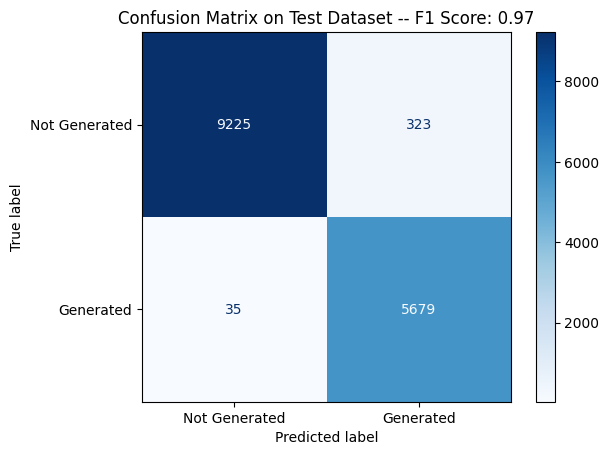

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test.detach().cpu().tolist(),  "Test")

In [ ]:
print(f'Test accuracy: {np.mean(y_test.to_numpy() == y_pred_test.detach().cpu().numpy())}')

Test accuracy: 0.9765430480933036


In [ ]:
# Save model + tokenizer
model.save_pretrained('/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/saved_model')
tokenizer.save_pretrained('/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/saved_model')

# This creates:
# ./saved_model/
#   ├── config.json           # Model configuration
#   ├── model.safetensors      # Model weights (new format)
#   └── tokenizer files        # Tokenizer vocab + config

('/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/saved_model/tokenizer_config.json',
 '/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/saved_model/special_tokens_map.json',
 '/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/saved_model/vocab.txt',
 '/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/saved_model/added_tokens.json')

In [ ]:
pretrained_model = DistilBertForSequenceClassification.from_pretrained('/content/gdrive/MyDrive/UofT/CSC2701/GPTOne/saved_model').to(device)

epoch: 100%|██████████| 239/239 [04:08<00:00,  1.04s/it]


Test accuracy: 0.9765430480933036


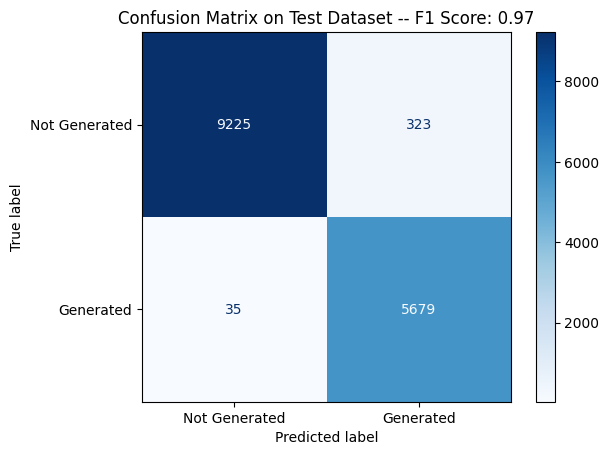

In [ ]:
y_pred_test_pretrained = torch.tensor([], device=device)

pretrained_model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc='epoch')):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        output = pretrained_model(input_ids=input_ids, attention_mask=attention_mask)

        pred = torch.argmax(output.logits, dim=1)
        y_pred_test_pretrained = torch.cat([y_pred_test_pretrained, pred])

displayConfusionMatrix(y_test, y_pred_test_pretrained.detach().cpu().tolist(),  "Test")
print(f'Test accuracy: {np.mean(y_test.to_numpy() == y_pred_test_pretrained.detach().cpu().numpy())}')